In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
def load_data(data_name):
    pkl_file = open(data_name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [ ]:
two_matrix = load_data('/content/drive/MyDrive/two_matrix')

In [ ]:
high_border = 45

In [ ]:
target = []
for i, prot in enumerate(two_matrix):
    if len(prot[1])<high_border:
        diff = abs(len(prot[1]) - high_border)
        target.append(np.pad(prot[1], ((0,diff),(0,diff)), 'constant')) 

In [ ]:
target = np.array(target)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('/content/drive/MyDrive/prot_feat.pkl', 'rb') as handle:
    prot = pickle.load(handle)

In [ ]:
df = pd.DataFrame([prot])
df = df.T
df = np.array(df)

In [ ]:
main = []
for i in range(len(df)):
  main.append(df[i][0])
main = np.array(main)

In [ ]:
train, train_val_test, train_label, target_val_test = train_test_split(main, target, test_size=0.3, random_state=13)
test, valid, test_label, valid_label = train_test_split(train_val_test, target_val_test, test_size=0.5, random_state=13)

In [ ]:
train.shape

(546, 45, 229)

In [ ]:
train.shape

(546, 45, 229)

In [ ]:
train_label.shape

(546, 45, 45)

In [ ]:
num_classes = 2
l2_lambda = 0.0001

In [ ]:
train = train.reshape(train.shape[0], train.shape[1], train.shape[2], 1)
test = test.reshape(test.shape[0], test.shape[1], test.shape[2], 1)
valid = valid.reshape(valid.shape[0], valid.shape[1], valid.shape[2], 1)
train_label = train_label.reshape(train_label.shape[0], 45*45)
test_label = test_label.reshape(test_label.shape[0], 45*45)
valid_label = valid_label.reshape(valid_label.shape[0],45*45)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding, Activation
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
#from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2 # L2-regularisation
from keras.models import Model

In [ ]:
from keras import models 

In [ ]:
def make_model_CNN():
        
    model = Sequential()
    
    model.add(Conv2D(filters = 4, kernel_size = (high_border, 5), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 8, kernel_size = (high_border, 3), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(MaxPooling2D())

    model.add(Conv2D(filters = 12, kernel_size = (high_border, 3), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.15))

    model.add(Conv2D(filters = 1, kernel_size = (high_border, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.15))

    model.add(Flatten())

    model.add(Dense(45 * 45))
    model.add(Activation("sigmoid"))
    
    return model

In [ ]:
model = make_model_CNN()

In [ ]:
model.build((None, 45, 229, 1))

In [ ]:
batch_size = 18
epochs = 25

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 45, 229, 4)        904       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 45, 229, 4)        0         
                                                                 
 dropout (Dropout)           (None, 45, 229, 4)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 229, 8)        4328      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 45, 229, 8)        0         
                                                                 
 dropout_1 (Dropout)         (None, 45, 229, 8)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 114, 8)       0

In [ ]:
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    if curr_session is not None:
        curr_session.close()
    tf.keras.backend.clear_session()
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
    tf.compat.v1.keras.backend.set_session(s)
    return s

In [ ]:
train.shape

(546, 45, 229, 1)

In [ ]:
valid.shape

(118, 45, 229, 1)

In [ ]:
train_label.shape

(546, 2025)

In [ ]:
valid_label.shape

(118, 2025)

In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
s = reset_tf_session()
INIT_LR = 5e-3

bst_model_path = 'CNN' + '.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=INIT_LR),
    metrics=[
        tf.keras.metrics.AUC(),
        tf.keras.metrics.BinaryAccuracy()
    ]
)

def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

train_dropout = model.fit(
    train, train_label,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    validation_data = (valid, valid_label),
    shuffle=True,
    verbose = 1,
    initial_epoch = 0
  )

In [ ]:
f1 = []
for i in range(epochs):
  f1.append(2* train_dropout.history['precision'][i] * train_dropout.history['recall'][i] / (train_dropout.history['precision'][i] + train_dropout.history['recall'][i]))

In [ ]:
f1_val = []
for i in range(epochs):
  f1_val.append(2* train_dropout.history['val_precision'][i] * train_dropout.history['val_recall'][i] / (train_dropout.history['val_precision'][i] + train_dropout.history['val_recall'][i]))

In [ ]:
max(f1_val)

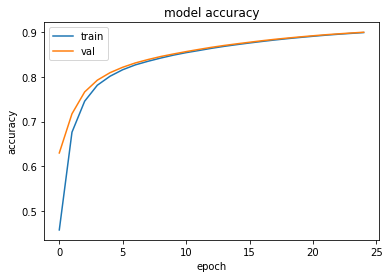

<Figure size 432x288 with 0 Axes>

In [ ]:
# plt.plot(train_dropout.history['AUC'])
plt.plot(f1)
plt.plot(f1_val)
# plt.plot(train_dropout.history['val_AUC'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('0pol.png')

In [ ]:
predicted = model.predict(test)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
tn, fp, fn, tp = confusion_matrix(np.round(test_label.reshape(54675)),np.round(predicted.reshape(54675))).ravel()

In [ ]:
(tn, fp, fn, tp)

(47955, 660, 807, 5253)

In [ ]:
persicion = tp / (tp+ fp)
recallz = tp / (tp +fn)
f1 = 2 * persicion * recallz / (recallz + persicion)
persicion,recallz,f1

(0.8883815322171487, 0.8668316831683168, 0.8774743172137309)

In [ ]:
predicted_reshaped = np.round(predicted.reshape(27, 45, 45))

In [ ]:
test_label_reshaped = np.round(test_label.reshape(27, 45, 45))

In [ ]:
from sklearn.metrics import precision_recall_curve

In [ ]:
pe, re, _ = precision_recall_curve(np.round(test_label.reshape(54675)),np.round(predicted.reshape(54675)),pos_label = 1)

In [ ]:
print(pe)
print(re)
print(2 *pe * re / (re + pe))

[0.11083676 0.88838153 1.        ]
[1.         0.86683168 0.        ]
[0.19955545 0.87747432 0.        ]


In [ ]:
def visualize(prot_number):
    visual_pred = predicted_reshaped[prot_number]
    visual_test = test_label_reshaped[prot_number]
    #visual_pred_alt = predicted_final_alt[prot_number]
    fig=plt.figure(figsize=(12, 12))
    fig.add_subplot(1, 1, 1)
    plt.imshow(visual_test, cmap='Paired')
    plt.imshow(visual_pred, alpha=.5, cmap='gray')
    #plt.imshow(visual_pred_alt, alpha=.8)
    plt.show()

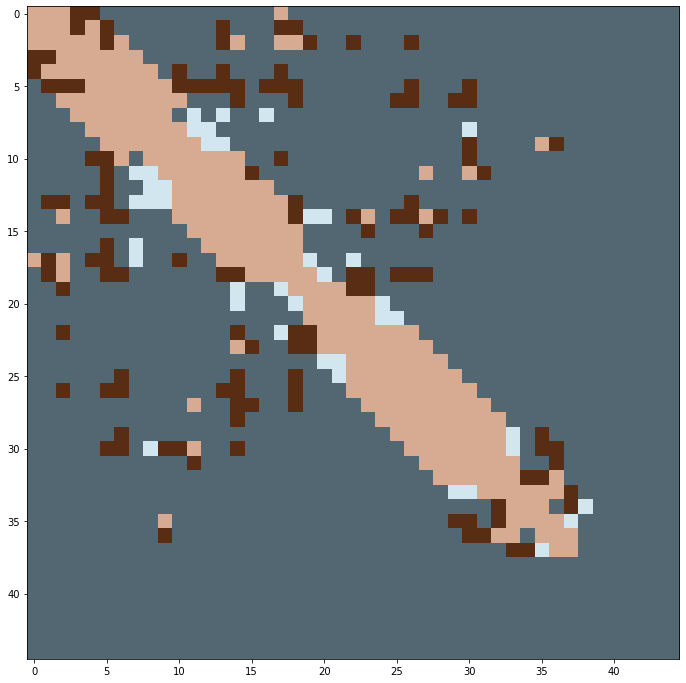

In [ ]:
visualize(10)